<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/NeuralNetworks/MNIST_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import jax
import time
from tqdm import tqdm

#Load MNIST Dataset

In [2]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [3]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())

batch_size = 128
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

## Train and test sets

In [4]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = np.array(mnist_dataset.train_labels)

N_train = 10000
train_images = train_images[0:N_train,:] #get a subset of the data
train_labels = train_labels[0:N_train]


# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = np.array(mnist_dataset_test.test_labels)


N_test = 10000
test_images = test_images[0:N_test,:] #get a subset of the data
test_labels = test_labels[0:N_test]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Plotting examples of MNIST dataset

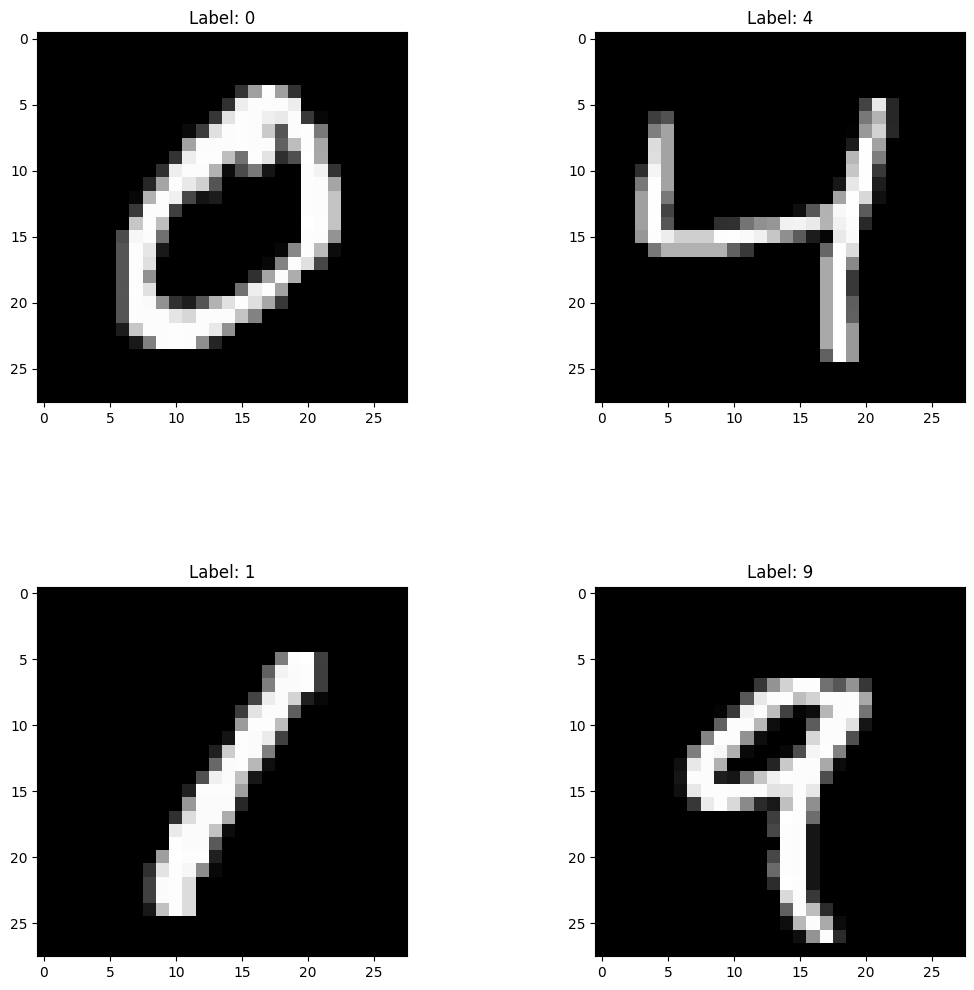

In [5]:
import matplotlib.pyplot as plt

def plot_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  for i in range(1, n_grid**2 + 1):
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.title(f"Label: {my_labels[i]}")

    img = train_images[i].reshape((28,28))
    plt.imshow(img, cmap='gray')

plot_MNIST_train_examples(train_labels)

# Linear Regression (LinR)

We think of linear regression as a [784 by 1] graph.

## Generate random starting paramaters

In [6]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale=1e-2):
  keys = jax.random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

key = jax.random.PRNGKey(int(time.time()))

In [7]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

## Create our function and our loss function

In [8]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def LinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  return (jnp.dot(w, x) + b)[0]

print("Lin Reg on 1st training example:")
print(LinR(params,train_images[0]))

Lin Reg on 1st training example:
12.570017


In [9]:
batched_LinR = jax.vmap(LinR, in_axes=(None, 0))

print("Lin Reg on all training example:")
print(batched_LinR(params,train_images))

Lin Reg on all training example:
[ 12.570017   8.062054 -10.813891 ...   5.260609  12.088157  13.727079]


In [10]:
def MSE_loss_for_LinR(params,images,target):
  preds = batched_LinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE loss of LinR on training set:")
print(MSE_loss_for_LinR(params,train_images,train_labels))

MSE loss of LinR on training set:
386.15805


# Training loop using gradient descent

In [11]:
import time

from functools import partial

@partial(jax.jit, static_argnames=['loss_func','step_size'])
def update_params(params, x, y, loss_func, step_size):
  grads = jax.grad(loss_func)(params, x, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

#trains ``params'' according to the given loss_func
def training_loop(loss_func, acc_func=None, num_epochs = 2, step_size = 0.01):
  global params
  saved_results = []
  for epoch in range(1,num_epochs+1):
      print(f"---Epoch {epoch}---")
      #Update the weights by gradient descent!
      start_time = time.time()
      for x, y in tqdm(training_generator):
          #turn the labels into one hot vectors
          grads = jax.grad(loss_func)(params, x, y)

          params = update_params(params, x, y, loss_func, step_size)

          #params = [(w - step_size * dw, b - step_size * db)
          #          for (w, b), (dw, db) in zip(params, grads)]

      #### A bunch of bookeeping here.... ####
      #Print and record stats of this epoch
      if acc_func != None:
        train_acc = acc_func(params, train_images, train_labels)
        test_acc = acc_func(params, test_images, test_labels)

      train_CE_loss = loss_func(params, train_images, train_labels)
      test_CE_loss = loss_func(params, test_images, test_labels)

      results_dict = {'epoch': epoch,
              'train_loss': np.copy(train_CE_loss).item(),
              'test_loss': np.copy(test_CE_loss).item(),
              }

      if acc_func != None:
        results_dict['train_acc'] = np.copy(train_acc).item()
        results_dict['test_acc'] = np.copy(test_acc).item()

      saved_results += [results_dict]

      epoch_time = time.time() - start_time
      print(f"--- {epoch_time:0.2f} sec---")
      if acc_func != None:
        print(f"  Train  acc: {train_acc:0.4f}")
        print(f"  Test   acc: {test_acc:0.4f}")
      print(f"  Train loss: {train_CE_loss:0.4f}")
      print(f"  Test  loss: {test_CE_loss:0.4f}")


  return saved_results

In [12]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_LinR,num_epochs=2,step_size = 0.00000001)

---Epoch 1---


100%|██████████| 469/469 [00:21<00:00, 21.97it/s]


--- 21.43 sec---
  Train loss: 114.7896
  Test  loss: 113.8207
---Epoch 2---


100%|██████████| 469/469 [00:12<00:00, 38.99it/s]

--- 12.05 sec---
  Train loss: 81.5348
  Test  loss: 80.5596


[{'epoch': 1, 'train_loss': 114.78955078125, 'test_loss': 113.82067108154297},
 {'epoch': 2, 'train_loss': 81.53475189208984, 'test_loss': 80.55962371826172}]

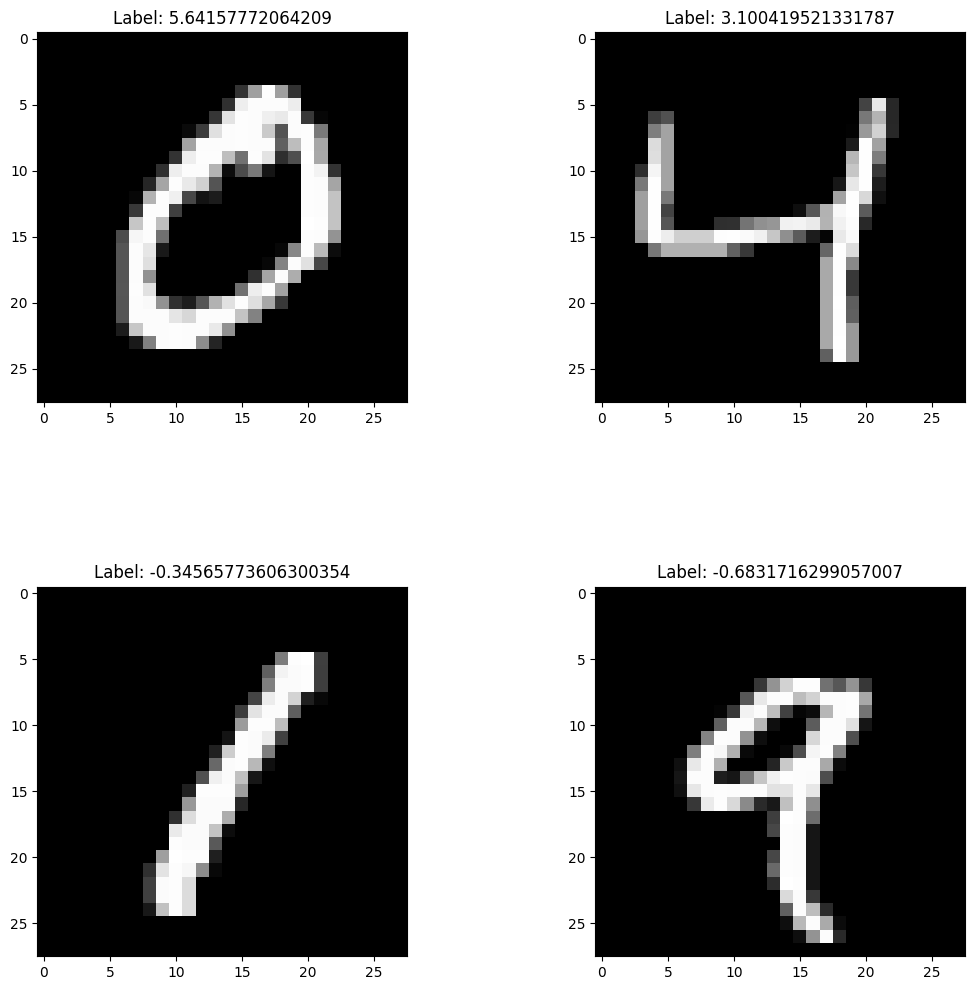

In [13]:
LinR_labels = batched_LinR(params, train_images)
plot_MNIST_train_examples(LinR_labels)

# Non-linear but still regression (NonLinR)

In [14]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key, scale=1e-4)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def NonLinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  return 9*sigmoid( (jnp.dot(w, x) + b) )[0]

print("NonLinR on a single example:")
print(NonLinR(params,train_images[2]))

batched_NonLinR = jax.vmap(NonLinR, in_axes=(None, 0))
print("NonLinR on a all examples:")
print(batched_NonLinR(params,train_images))

def MSE_loss_for_NonLinR(params,images,target):
  preds = batched_NonLinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE of train set for NonLin R")
print(MSE_loss_for_NonLinR(params,train_images,train_labels))

NonLinR on a single example:
4.2569246
NonLinR on a all examples:
[4.7824535 4.6812983 4.2569246 ... 4.618336  4.7716527 4.8083754]
MSE of train set for NonLin R
8.343139


In [15]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_NonLinR,step_size = 0.0000001)

---Epoch 1---


100%|██████████| 469/469 [00:16<00:00, 28.47it/s]


--- 16.50 sec---
  Train loss: 18.5616
  Test  loss: 18.3370
---Epoch 2---


100%|██████████| 469/469 [00:15<00:00, 30.50it/s]

--- 15.41 sec---
  Train loss: 16.2105
  Test  loss: 15.9232


[{'epoch': 1,
  'train_loss': 18.561649322509766,
  'test_loss': 18.33699607849121},
 {'epoch': 2,
  'train_loss': 16.210542678833008,
  'test_loss': 15.923221588134766}]

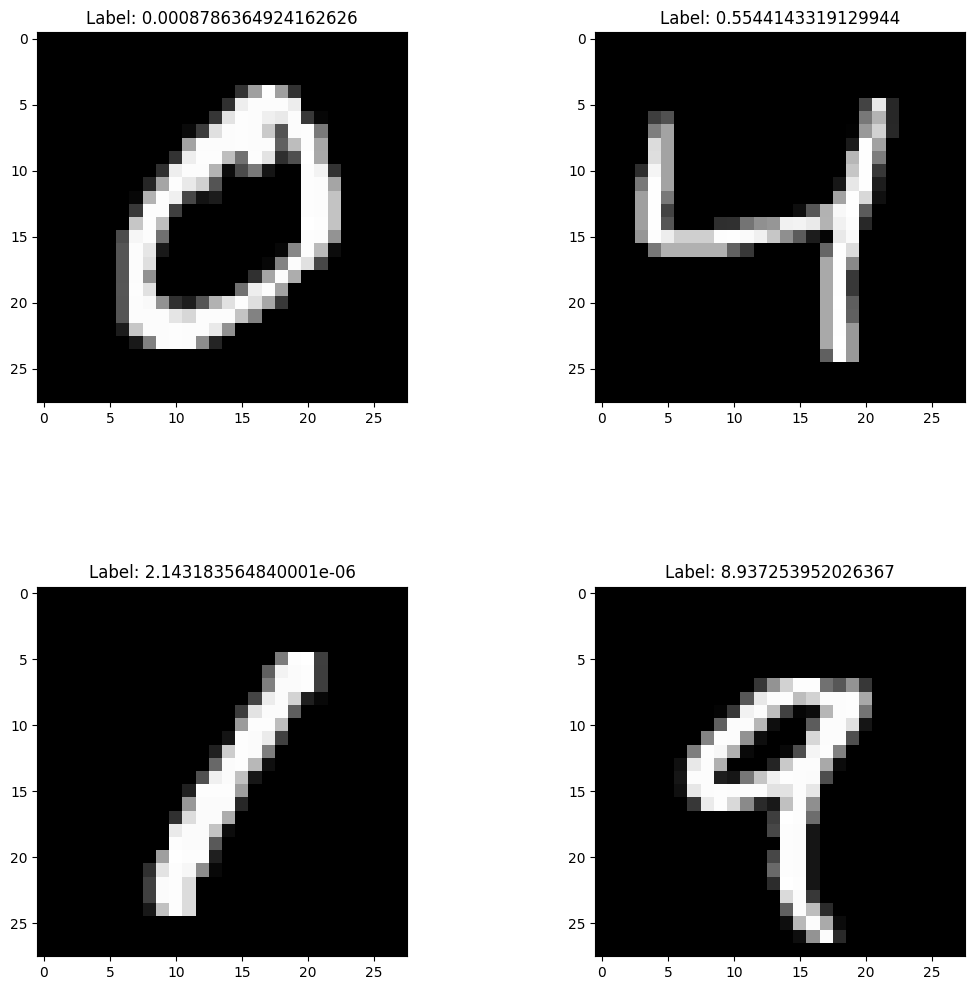

In [16]:
NonLinR_labels = batched_NonLinR(params, train_images)
plot_MNIST_train_examples(NonLinR_labels)

# Logisitic Regression (LogiR)

In [17]:
#Initialize Parameters

layer_sizes = [784, 10]
params = init_network_params(layer_sizes, key)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def LogiR_logP(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  logits = jnp.dot(w, x) + b
  logits = logits - jnp.max(logits)
  logP = logits - jnp.log(jnp.sum(jnp.exp(logits)))
  return logP

print("LogiR on one example:")
print(LogiR_logP(params, train_images[0]))

batched_LogiR_logP = jax.vmap(LogiR_logP, in_axes=(None, 0))

print("LogiR on all examples:")
print(batched_LogiR_logP(params, train_images))



def CE_loss_for_LogiR(params,images,target):
  preds = batched_LogiR_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot)


print("CE loss of LogiR on all example:")
print(CE_loss_for_LogiR(params,train_images,train_labels))

LogiR on one example:
[ -92.338066    0.        -33.385487  -63.006428  -29.634785  -73.4574
  -54.497604 -125.891235  -36.51806  -100.30963 ]
LogiR on all examples:
[[-9.23380737e+01  0.00000000e+00 -3.33854828e+01 ... -1.25891235e+02
  -3.65180664e+01 -1.00309654e+02]
 [-3.19290314e+01 -1.73102963e+00 -1.98264084e+01 ... -6.41249619e+01
  -1.58576336e+01 -4.29887848e+01]
 [-1.89170628e+01 -1.03860550e+01 -1.70024149e-02 ... -1.23260002e+01
  -1.36328201e+01 -4.52838850e+00]
 ...
 [-5.02628822e+01 -7.71225023e-04 -5.75696030e+01 ... -6.32559357e+01
  -7.16797686e+00 -5.45754700e+01]
 [-3.82584877e+01 -9.96047974e+00 -4.30099440e+00 ... -5.97583771e+01
  -1.10005684e+01 -2.04948483e+01]
 [-3.80559692e+01 -1.01907194e+00 -3.73624763e+01 ... -5.80621452e+01
  -4.47740912e-01 -3.87841568e+01]]
CE loss of LogiR on all example:
3.7224312


In [18]:
layer_sizes = [784, 10]
params = init_network_params(layer_sizes, key)

def top1_acc_LogiR(params, images, target_class):
  predicted_class = jnp.argmax(batched_LogiR_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_LogiR,top1_acc_LogiR,num_epochs=5,step_size = 0.01)
print("Done!")

---Epoch 1---


100%|██████████| 469/469 [00:19<00:00, 23.50it/s]


--- 20.32 sec---
  Train  acc: 0.8670
  Test   acc: 0.8603
  Train loss: 1.6046
  Test  loss: 1.7404
---Epoch 2---


100%|██████████| 469/469 [00:17<00:00, 26.82it/s]


--- 17.53 sec---
  Train  acc: 0.8638
  Test   acc: 0.8524
  Train loss: 1.7966
  Test  loss: 2.0066
---Epoch 3---


100%|██████████| 469/469 [00:15<00:00, 30.02it/s]


--- 15.67 sec---
  Train  acc: 0.8682
  Test   acc: 0.8567
  Train loss: 1.8198
  Test  loss: 2.0663
---Epoch 4---


100%|██████████| 469/469 [00:15<00:00, 30.17it/s]


--- 15.59 sec---
  Train  acc: 0.8674
  Test   acc: 0.8583
  Train loss: 1.5269
  Test  loss: 1.7224
---Epoch 5---


100%|██████████| 469/469 [00:15<00:00, 30.00it/s]


--- 15.69 sec---
  Train  acc: 0.8938
  Test   acc: 0.8859
  Train loss: 1.1484
  Test  loss: 1.3051
Done!


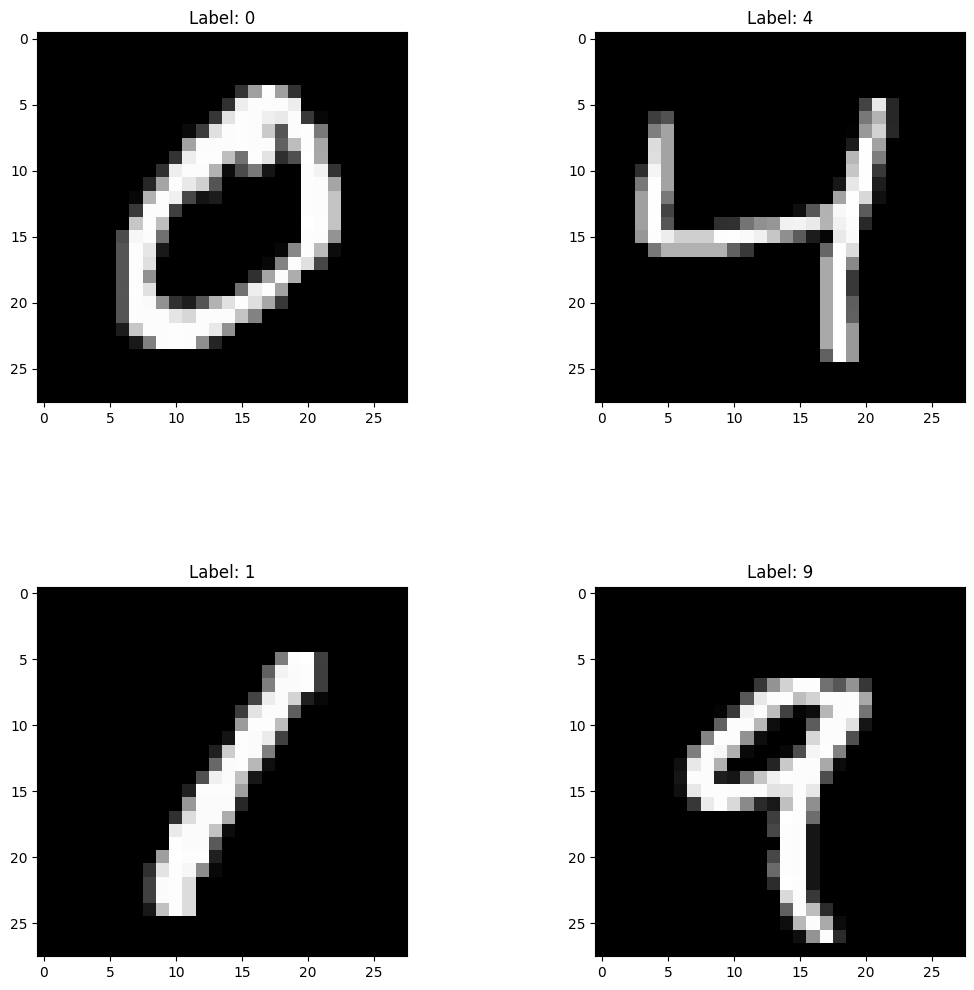

In [19]:
LogiR_labels = batched_LogiR_logP(params, train_images)
plot_MNIST_train_examples(jnp.argmax(LogiR_labels,axis=1))

## Multi-layer perceptron with cross entropy loss (MLP)

In [20]:
layer_sizes = [784, 784, 10]
params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  return jnp.maximum(0, x) # compute the element-wise function

def MLP_logP(params, image):
    # per-example predictions
    x = image
    # first layer is feedforward
    w, b = params[0]
    x = (jnp.dot(w, x) + b)
    x_relu = relu(x)

    for w, b in params[1:-1]:
        # skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = relu(x)

    final_w, final_b = params[-1]
    logits = (jnp.dot(final_w,  x) + final_b)
    logits = logits - jnp.max(logits)
    return logits - jnp.log(jnp.sum(jnp.exp(logits)))

print("MLP logP on a single examples")
print(MLP_logP(params, train_images[0]))

MLP logP on a single examples
[-13.912718   -1.0752643  -0.5368084 -14.820466  -19.706944  -18.9766
 -21.173212   -2.6016555 -15.278195  -10.445041 ]


In [21]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_MLP_logP = jax.vmap(MLP_logP, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
print("MLP logP on all examples")
batched_preds = batched_MLP_logP(params, train_images)
print(batched_preds)

MLP logP on all examples
[[-1.3912711e+01 -1.0752664e+00 -5.3680748e-01 ... -2.6016521e+00
  -1.5278186e+01 -1.0445039e+01]
 [-3.4432938e+00 -9.3439884e+00 -9.2629328e+00 ... -6.4938750e+00
  -1.8083992e+01 -7.7907242e-02]
 [-9.1603308e+00 -1.3563956e+00 -4.8726473e+00 ... -4.2145526e-01
  -2.7375140e+00 -1.0233585e+01]
 ...
 [-8.9824152e+00 -4.7405214e+00 -1.2668845e+01 ... -1.1832175e-02
  -1.6029095e+01 -1.2248982e+01]
 [-7.7342505e+00 -1.6063444e+01 -1.4192261e+01 ... -4.3883230e-04
  -1.7183823e+01 -2.0019886e+01]
 [-2.4424740e-03 -6.3260550e+00 -1.9468718e+01 ... -7.3395791e+00
  -1.7700981e+01 -1.8319681e+01]]


# Loss function

In [22]:
def CE_loss_for_MLP(params, images, target):
  preds = batched_MLP_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot)

print("CE loss for the the MLP")
print(CE_loss_for_MLP(params, train_images, train_labels))


CE loss for the the MLP
1.0529249


In [23]:
layer_sizes = [784, 784, 784, 10]
params = init_network_params(layer_sizes, key)


def top1_acc_MLP(params, images, target_class):
  predicted_class = jnp.argmax(batched_MLP_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_MLP, top1_acc_MLP, num_epochs=10)

---Epoch 1---


100%|██████████| 469/469 [00:25<00:00, 18.74it/s]


--- 25.11 sec---
  Train  acc: 0.9259
  Test   acc: 0.9284
  Train loss: 0.0249
  Test  loss: 0.0243
---Epoch 2---


100%|██████████| 469/469 [00:17<00:00, 27.48it/s]


--- 17.14 sec---
  Train  acc: 0.9439
  Test   acc: 0.9434
  Train loss: 0.0187
  Test  loss: 0.0189
---Epoch 3---


100%|██████████| 469/469 [00:19<00:00, 24.27it/s]


--- 19.39 sec---
  Train  acc: 0.9567
  Test   acc: 0.9531
  Train loss: 0.0150
  Test  loss: 0.0156
---Epoch 4---


100%|██████████| 469/469 [00:16<00:00, 27.67it/s]


--- 17.01 sec---
  Train  acc: 0.9638
  Test   acc: 0.9585
  Train loss: 0.0125
  Test  loss: 0.0135
---Epoch 5---


100%|██████████| 469/469 [00:17<00:00, 27.34it/s]


--- 17.22 sec---
  Train  acc: 0.9689
  Test   acc: 0.9629
  Train loss: 0.0107
  Test  loss: 0.0121
---Epoch 6---


100%|██████████| 469/469 [00:18<00:00, 26.03it/s]


--- 18.09 sec---
  Train  acc: 0.9729
  Test   acc: 0.9652
  Train loss: 0.0093
  Test  loss: 0.0112
---Epoch 7---


100%|██████████| 469/469 [00:17<00:00, 26.95it/s]


--- 17.46 sec---
  Train  acc: 0.9780
  Test   acc: 0.9672
  Train loss: 0.0082
  Test  loss: 0.0104
---Epoch 8---


100%|██████████| 469/469 [00:17<00:00, 27.16it/s]


--- 17.33 sec---
  Train  acc: 0.9809
  Test   acc: 0.9691
  Train loss: 0.0073
  Test  loss: 0.0098
---Epoch 9---


100%|██████████| 469/469 [00:17<00:00, 26.99it/s]


--- 17.44 sec---
  Train  acc: 0.9826
  Test   acc: 0.9709
  Train loss: 0.0066
  Test  loss: 0.0094
---Epoch 10---


100%|██████████| 469/469 [00:18<00:00, 25.70it/s]

--- 18.31 sec---
  Train  acc: 0.9844
  Test   acc: 0.9715
  Train loss: 0.0059
  Test  loss: 0.0090


[{'epoch': 1,
  'train_loss': 0.02493101917207241,
  'test_loss': 0.024302523583173752,
  'train_acc': 0.9258999824523926,
  'test_acc': 0.9283999800682068},
 {'epoch': 2,
  'train_loss': 0.018708130344748497,
  'test_loss': 0.018869178369641304,
  'train_acc': 0.9438999891281128,
  'test_acc': 0.943399965763092},
 {'epoch': 3,
  'train_loss': 0.01496058888733387,
  'test_loss': 0.01561717689037323,
  'train_acc': 0.9566999673843384,
  'test_acc': 0.9530999660491943},
 {'epoch': 4,
  'train_loss': 0.012455880641937256,
  'test_loss': 0.013539262115955353,
  'train_acc': 0.9637999534606934,
  'test_acc': 0.9584999680519104},
 {'epoch': 5,
  'train_loss': 0.010659144259989262,
  'test_loss': 0.012142473831772804,
  'train_acc': 0.9688999652862549,
  'test_acc': 0.9628999829292297},
 {'epoch': 6,
  'train_loss': 0.009292922914028168,
  'test_loss': 0.011153671890497208,
  'train_acc': 0.9728999733924866,
  'test_acc': 0.9651999473571777},
 {'epoch': 7,
  'train_loss': 0.00820225477218628,

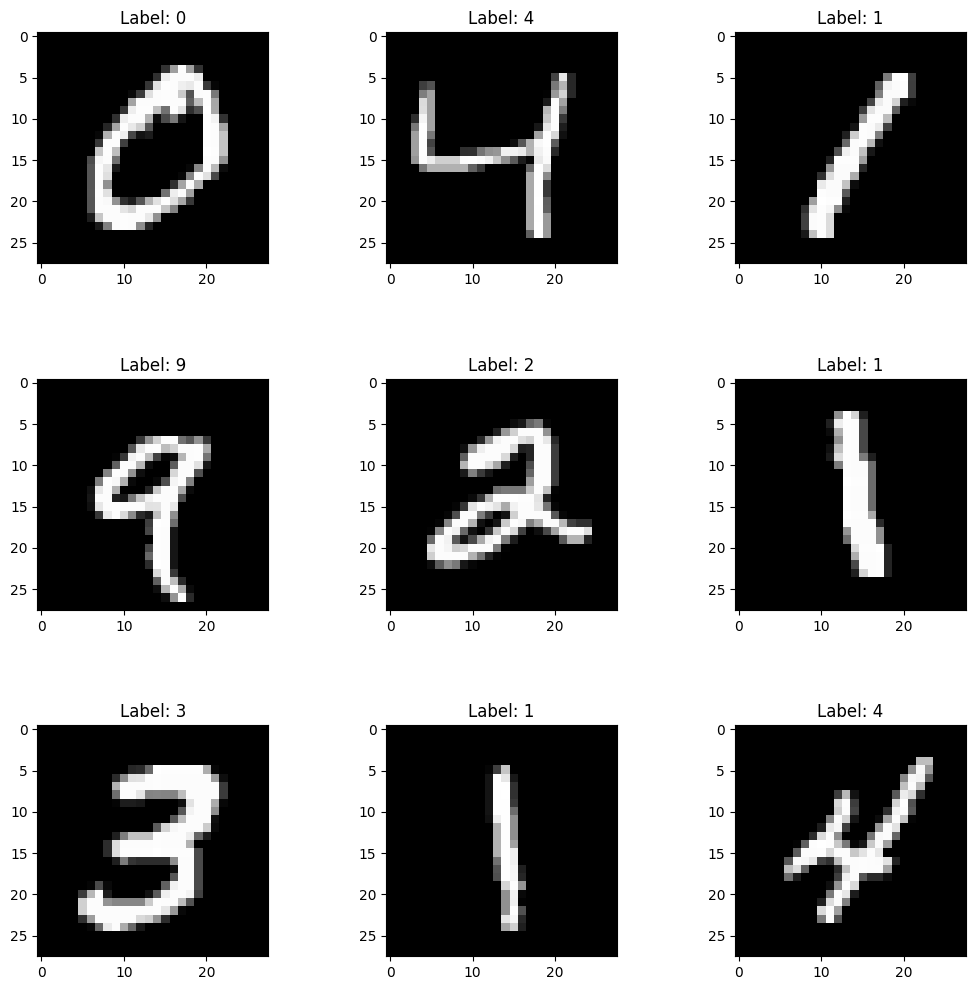

In [24]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_MNIST_train_examples( MLP_labels,n_grid = 3)

In [25]:
def plot_incorrect_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  image_ix = 0
  for i in range(1, n_grid**2 + 1):
    image_ix += 1
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    while train_labels[image_ix] == my_labels[image_ix]:
      image_ix += 1
    plt.title(f"My Label: {my_labels[image_ix]}, Actual: {train_labels[image_ix]}")
    img = train_images[image_ix].reshape((28,28))
    plt.imshow(img, cmap='gray')

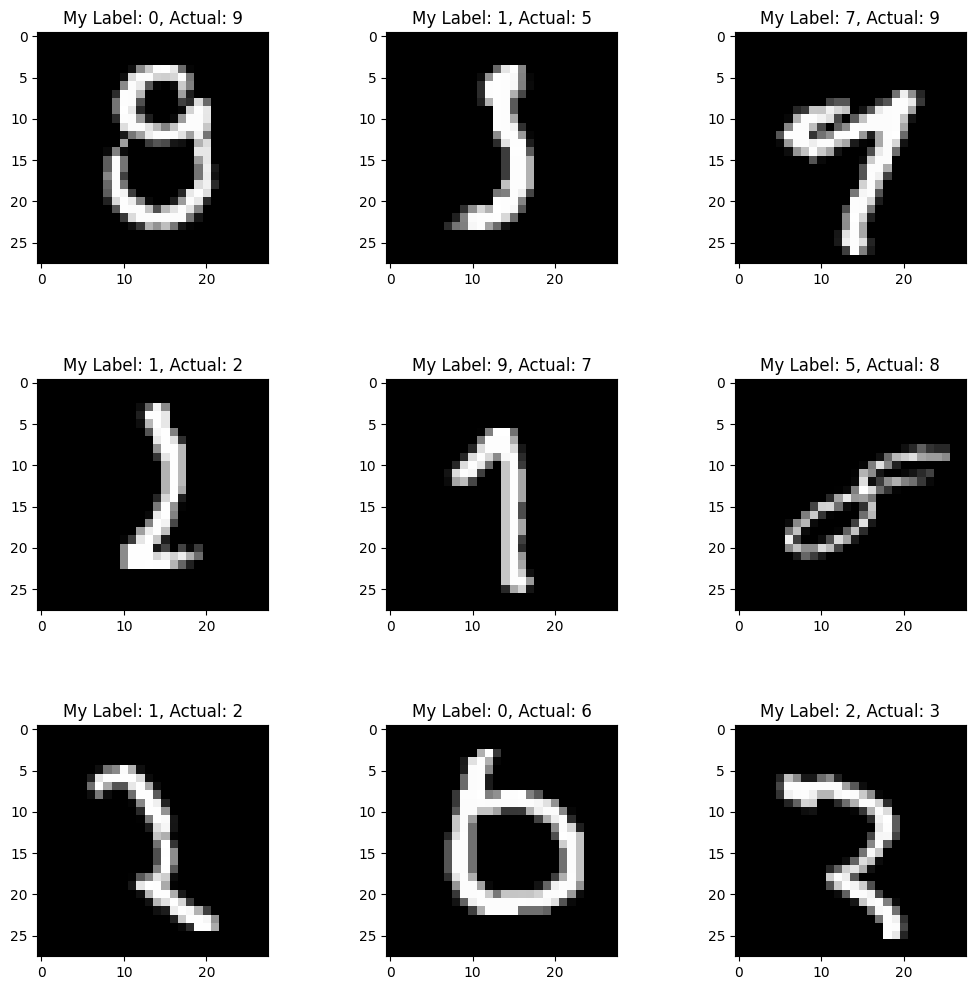

In [26]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_incorrect_MNIST_train_examples( MLP_labels,n_grid = 3)